# Congress Twitter – Combined Analysis, Topics, and Word Clouds

AI Usage: We used AI to help construct a template for analysis code and fix bugs in the code

## 0. Setup – Imports and Configuration

In [1]:
from pathlib import Path
from collections import Counter
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import networkx as nx

from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import LatentDirichletAllocation


# -----------------------------
# Paths / config
# -----------------------------
MONTHLY_DIR = Path("classdata/Group Projects/Group 6/Final Code and Data/monthly_tweets")   # folder with tweets_YYYY_MM.csv
USERS_CSV   = Path("classdata/Group Projects/Group 6/Final Code and Data/users_df.csv")     # cleaned users dataframe

# Pattern for monthly files
MONTHLY_PATTERN = "tweets_*.csv"

OUT_DIR = Path("classdata/Group Projects/Group 6/Final Code and Data/outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# For LDA
N_TOPICS = 5

In [2]:
# Basic party color palette (simplified)
PARTY_COLORS = {
    "D": "blue",
    "R": "red",
    "I": "green",
    None: "gray"
}

def party_color_series(index):
    return [PARTY_COLORS.get(str(p), "gray") for p in index]


## 1. Load Monthly Tweets and Users

In [3]:
# Load all monthly tweet files and concatenate into a single DataFrame

csv_paths = sorted(MONTHLY_DIR.glob(MONTHLY_PATTERN))
if not csv_paths:
    raise FileNotFoundError(f"No files matching {MONTHLY_PATTERN} found in {MONTHLY_DIR.resolve()}")

dfs = []
for path in csv_paths:
    df = pd.read_csv(path, low_memory=False)
    dfs.append(df)

tweets = pd.concat(dfs, ignore_index=True)

tweets["text"] = tweets["text"].astype(str)
tweets = tweets[~tweets["text"].fillna("").str.startswith("RT")]
print(f"Loaded {len(tweets):,} tweets from {len(csv_paths)} monthly files")

Loaded 245,858 tweets from 27 monthly files


In [4]:
# Ensure created_at is datetime and create a month column
tweets["created_at"] = pd.to_datetime(tweets["created_at"], errors="coerce")
tweets["month"] = tweets["created_at"].dt.to_period("M")

In [5]:
# Load users_df.csv
users_df = pd.read_csv(USERS_CSV, low_memory=False)
print(f"Loaded {len(users_df):,} users from {USERS_CSV}")

Loaded 548 users from classdata/Group Projects/Group 6/Final Code and Data/users_df.csv


In [6]:
# Merge tweets with users on user_id

tweet_uid_col = [c for c in tweets.columns   if c.lower() == "user_id"][0]
user_uid_col  = [c for c in users_df.columns if c.lower() == "user_id"][0]

# Merge
tweets_users = tweets.merge(
    users_df,
    left_on=tweet_uid_col,
    right_on=user_uid_col,
    how="left",
    suffixes=("", "_user")
)

print(f"Rows:     {tweets_users.shape[0]:,}")
print(f"Columns:  {tweets_users.shape[1]:,}")

Rows:     245,858
Columns:  37


## 2. Descriptive Statistics and Visual Summaries

First tweet: 2012-10-01 00:35:27
Last tweet: 2014-12-29 23:36:20


n_tweets
month            
2014-08      9490
2014-09     11692
2014-10     10258
2014-11      8378
2014-12      7679

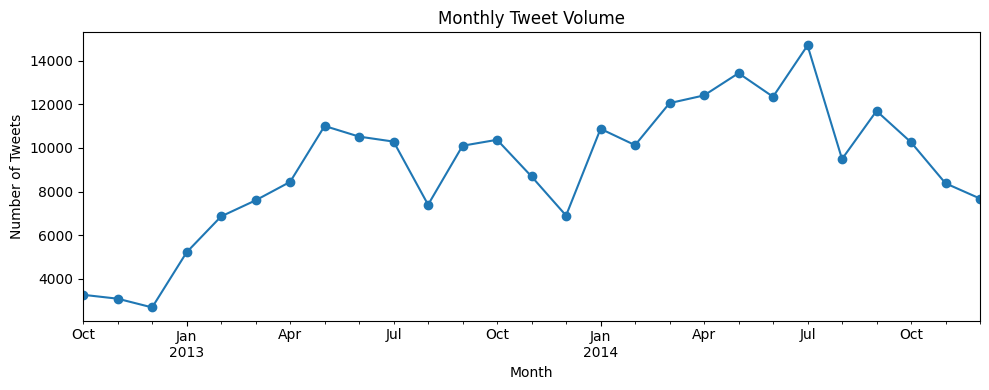

In [7]:
# Time coverage and monthly tweet volume

print("First tweet:", tweets_users["created_at"].min())
print("Last tweet:",  tweets_users["created_at"].max())

monthly_counts = (
    tweets_users
    .groupby("month")["id"]
    .count()
    .rename("n_tweets")
    .to_frame()
)

display(monthly_counts.tail())

plt.figure(figsize=(10, 4))
monthly_counts["n_tweets"].plot(kind="line", marker="o")
plt.title("Monthly Tweet Volume")
plt.xlabel("Month")
plt.ylabel("Number of Tweets")
plt.tight_layout()
plt.tight_layout()
plt.savefig(OUT_DIR / "monthly_tweet_volume.png", dpi=300, bbox_inches="tight")
plt.show()

party         D     I       R
month                        
2014-07  5655.0  33.0  9005.0
2014-08  3876.0  29.0  5585.0
2014-10  3927.0  19.0  6312.0
2014-11  3215.0  21.0  5142.0
2014-12  3227.0  50.0  4402.0

<Figure size 1000x400 with 0 Axes>

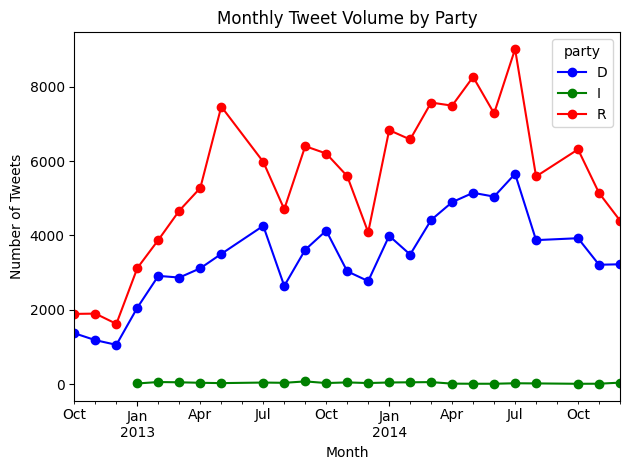

In [8]:
# Monthly tweet volume by party (multi-line)

monthly_party_counts = (
    tweets_users
    .groupby(["month", "party"])["id"]
    .count()
    .unstack("party")
    .sort_index()
)

display(monthly_party_counts.tail())

plt.figure(figsize=(10, 4))
colors = [PARTY_COLORS.get(str(p), "gray") for p in monthly_party_counts.columns]
monthly_party_counts.plot(kind="line", marker="o", color=colors)
plt.title("Monthly Tweet Volume by Party")
plt.xlabel("Month")
plt.ylabel("Number of Tweets")
plt.tight_layout()
plt.tight_layout()
plt.savefig(OUT_DIR / "monthly_tweet_volume_by_party.png", dpi=300, bbox_inches="tight")
plt.show()

screen_name
RepSamGraves       2022
MikeCrapo          1988
RepChrisCollins    1926
RepHuizenga        1840
RepLynnJenkins     1810
GrahamBlog         1754
DesJarlaisTN04     1747
RepStevePearce     1621
RepDennisRoss      1565
SenToomey          1554
RepDaveJoyce       1536
SenatorMenendez    1534
JudgeCarter        1518
DarrellIssa        1466
RepErikPaulsen     1461
Name: n_tweets, dtype: int64

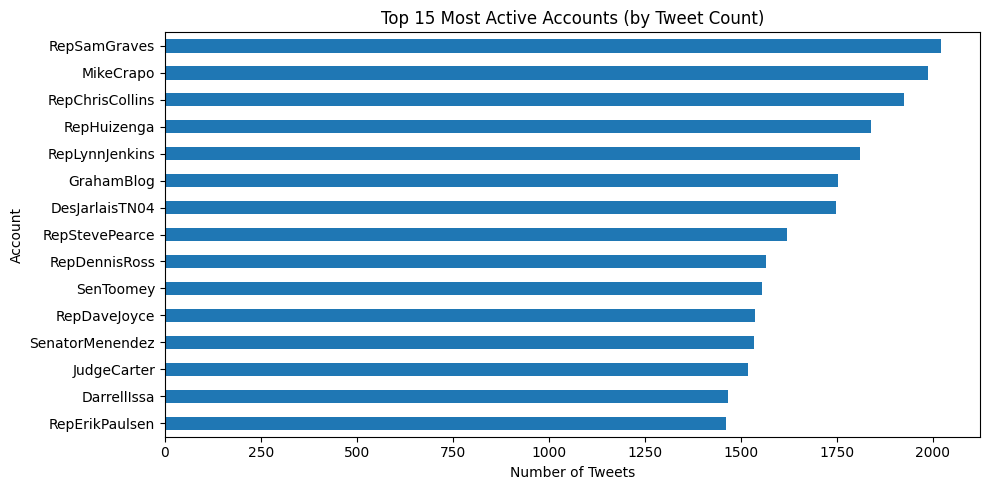

In [9]:
# Top 15 most active accounts by tweet count

top_accounts = (
    tweets_users
    .groupby("screen_name")["id"]
    .count()
    .sort_values(ascending=False)
    .head(15)
    .rename("n_tweets")
)

display(top_accounts)

plt.figure(figsize=(10, 5))
top_accounts.sort_values().plot(kind="barh")
plt.title("Top 15 Most Active Accounts (by Tweet Count)")
plt.xlabel("Number of Tweets")
plt.ylabel("Account")
plt.tight_layout()
plt.tight_layout()
plt.savefig(OUT_DIR / "top_15_most_active_accounts_by_tweet_count.png", dpi=300, bbox_inches="tight")
plt.show()

party
R    137244
D     85458
I       942
Name: n_tweets, dtype: int64

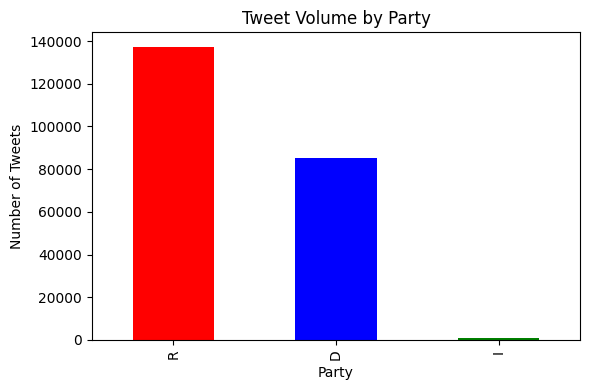

In [10]:
# Tweet volume by party

party_counts = (
    tweets_users
    .groupby("party")["id"]
    .count()
    .sort_values(ascending=False)
    .rename("n_tweets")
)

display(party_counts)

plt.figure(figsize=(6, 4))
party_counts.plot(kind="bar", color=party_color_series(party_counts.index))
plt.title("Tweet Volume by Party")
plt.xlabel("Party")
plt.ylabel("Number of Tweets")
plt.tight_layout()
plt.tight_layout()
plt.savefig(OUT_DIR / "tweet_volume_by_party.png", dpi=300, bbox_inches="tight")
plt.show()

### 2a. Engagement Over Time by Party

Track how engagement (likes + retweets) and tweet volume evolve over time by party. Plots are saved under `outputs/`.

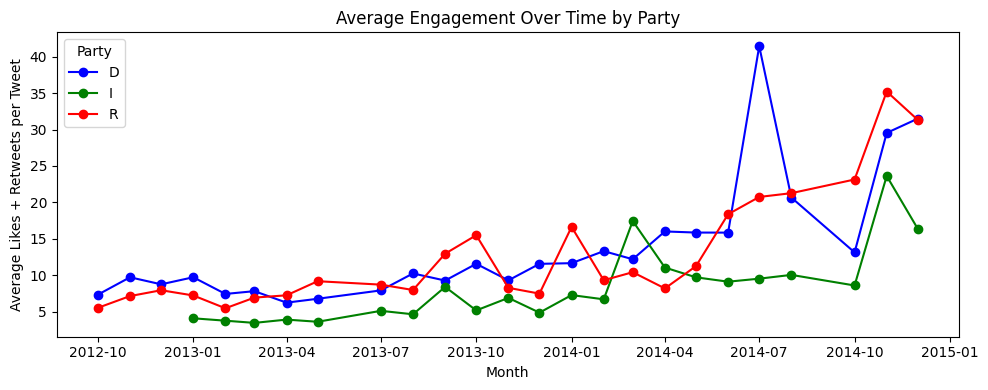

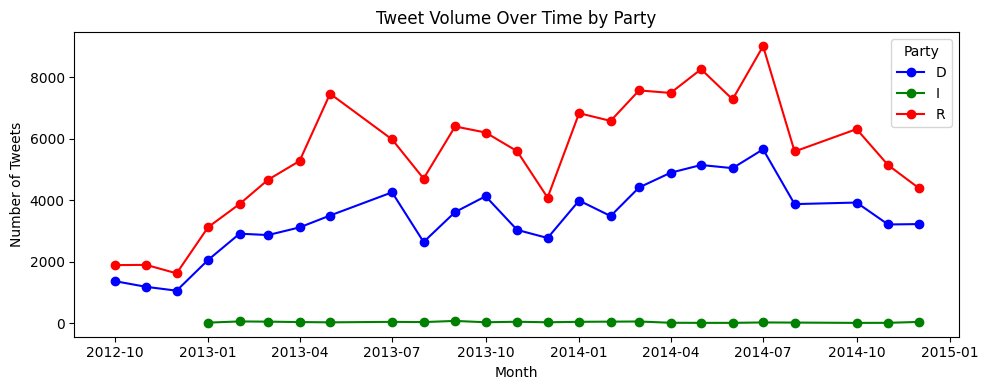

In [11]:
# Engagement over time by party (likes + retweets) and tweet volume

if {"retweet_count", "favorite_count"}.issubset(tweets_users.columns):
    tweets_users["engagement"] = (
        tweets_users["retweet_count"].fillna(0) +
        tweets_users["favorite_count"].fillna(0)
    )

    eng_time = (
        tweets_users
        .groupby(["month", "party"])["engagement"]
        .mean()
        .unstack("party")
        .sort_index()
    )

    plt.figure(figsize=(10, 4))
    for party in eng_time.columns:
        plt.plot(
            eng_time.index.to_timestamp(),
            eng_time[party],
            label=str(party),
            color=PARTY_COLORS.get(str(party), "gray"),
            marker="o"
        )
    plt.title("Average Engagement Over Time by Party")
    plt.xlabel("Month")
    plt.ylabel("Average Likes + Retweets per Tweet")
    plt.legend(title="Party")
    plt.tight_layout()
    out_path = OUT_DIR / "engagement_over_time_by_party.png"
    plt.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.show()

    vol_time = (
        tweets_users
        .groupby(["month", "party"])["id"]
        .count()
        .unstack("party")
        .sort_index()
    )

    plt.figure(figsize=(10, 4))
    for party in vol_time.columns:
        plt.plot(
            vol_time.index.to_timestamp(),
            vol_time[party],
            label=str(party),
            color=PARTY_COLORS.get(str(party), "gray"),
            marker="o"
        )
    plt.title("Tweet Volume Over Time by Party")
    plt.xlabel("Month")
    plt.ylabel("Number of Tweets")
    plt.legend(title="Party")
    plt.tight_layout()
    out_path = OUT_DIR / "tweet_volume_over_time_by_party.png"
    plt.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.show()

party
R    306
D    239
I      3
Name: n_accounts, dtype: int64

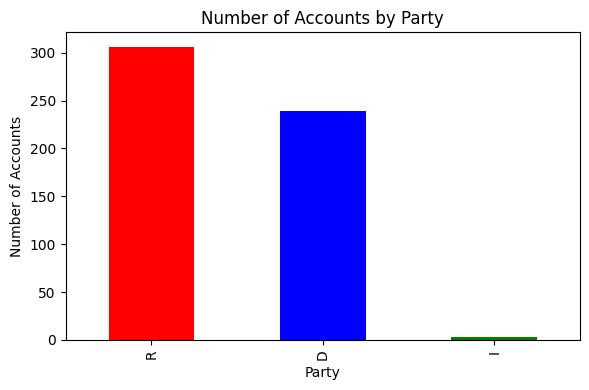

In [12]:
# Number of accounts per party

accounts_per_party = (
    users_df
    .groupby("party")[user_uid_col]
    .nunique()
    .sort_values(ascending=False)
    .rename("n_accounts")
)

display(accounts_per_party)

plt.figure(figsize=(6, 4))
accounts_per_party.plot(kind="bar", color=party_color_series(accounts_per_party.index))
plt.title("Number of Accounts by Party")
plt.xlabel("Party")
plt.ylabel("Number of Accounts")
plt.tight_layout()
plt.tight_layout()
plt.savefig(OUT_DIR / "number_of_accounts_by_party.png", dpi=300, bbox_inches="tight")
plt.show()

party
I    1706598.0
R     215798.0
D      77020.0
Name: followers_count, dtype: float64

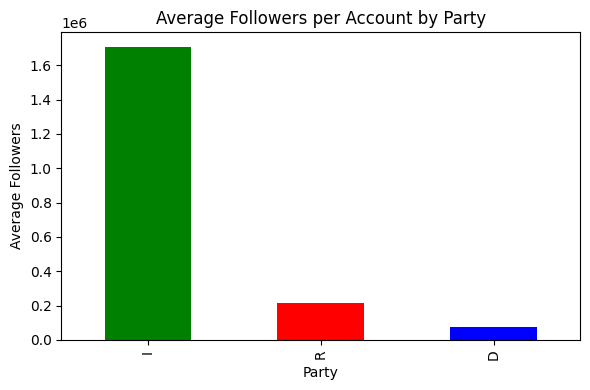

In [13]:
# Average followers per account by party

followers_by_party = (
    users_df
    .groupby("party")["followers_count"]
    .mean()
    .round(0)
    .sort_values(ascending=False)
)

display(followers_by_party)

plt.figure(figsize=(6, 4))
followers_by_party.plot(kind="bar", color=party_color_series(followers_by_party.index))
plt.title("Average Followers per Account by Party")
plt.xlabel("Party")
plt.ylabel("Average Followers")
plt.tight_layout()
plt.tight_layout()
plt.savefig(OUT_DIR / "average_followers_per_account_by_party.png", dpi=300, bbox_inches="tight")
plt.show()

party
R    682.8
D    537.5
I    471.0
Name: avg_tweets_per_account, dtype: float64

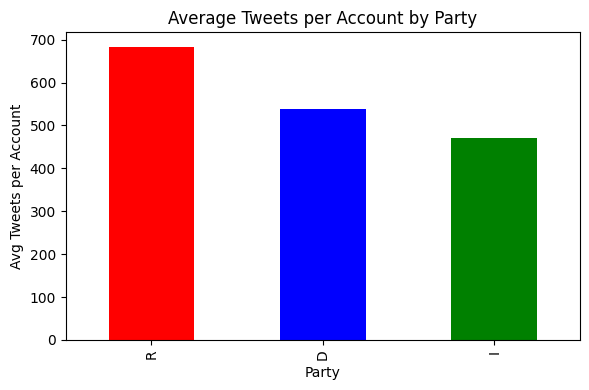

In [14]:
# Average tweets per account by party

tweets_per_account_party = (
    tweets_users
    .groupby(["party", tweet_uid_col])["id"]
    .count()
    .groupby("party")
    .mean()
    .round(1)
    .rename("avg_tweets_per_account")
    .sort_values(ascending=False)
)

display(tweets_per_account_party)

plt.figure(figsize=(6, 4))
tweets_per_account_party.plot(kind="bar", color=party_color_series(tweets_per_account_party.index))
plt.title("Average Tweets per Account by Party")
plt.xlabel("Party")
plt.ylabel("Avg Tweets per Account")
plt.tight_layout()
plt.tight_layout()
plt.savefig(OUT_DIR / "average_tweets_per_account_by_party.png", dpi=300, bbox_inches="tight")
plt.show()

favorite_count  retweet_count  engagement
month                                             
2014-08            8.01          12.97       20.98
2014-09            8.00          11.56       19.56
2014-10            7.08          12.20       19.28
2014-11           13.61          19.40       33.01
2014-12           12.93          18.37       31.30

<Figure size 1000x400 with 0 Axes>

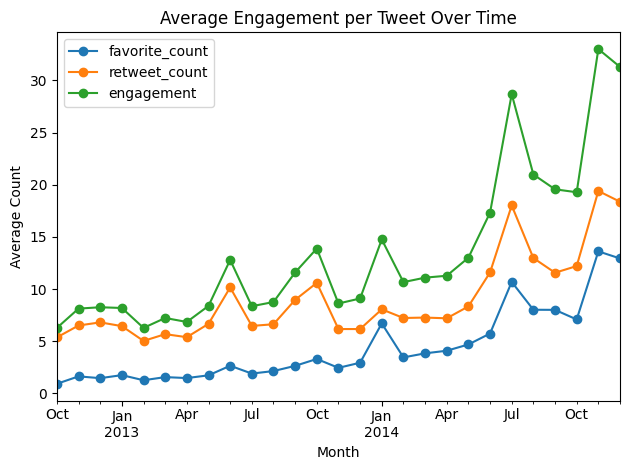

<Figure size 600x400 with 0 Axes>

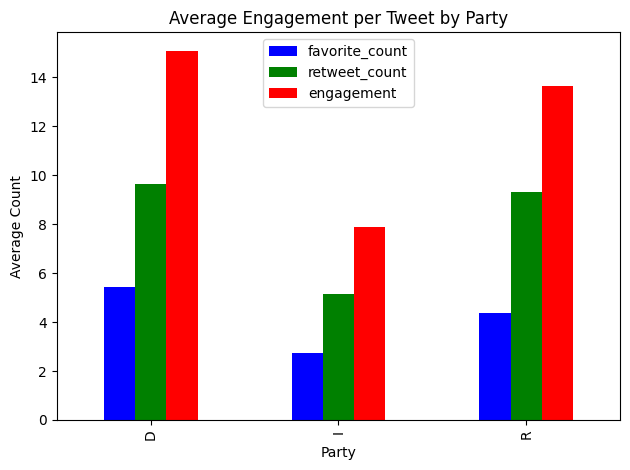

In [15]:
# Engagement over time and by party

for col in ["favorite_count", "retweet_count"]:
    tweets_users[col] = pd.to_numeric(tweets_users[col], errors="coerce")

tweets_users["engagement"] = tweets_users[["favorite_count","retweet_count"]].fillna(0).sum(axis=1)

eng = (
    tweets_users
    .groupby("month")[["favorite_count","retweet_count","engagement"]]
    .mean()
    .round(2)
)

display(eng.tail())

plt.figure(figsize=(10, 4))
eng.plot(kind="line", marker="o")
plt.title("Average Engagement per Tweet Over Time")
plt.xlabel("Month")
plt.ylabel("Average Count")
plt.tight_layout()
plt.tight_layout()
plt.savefig(OUT_DIR / "average_engagement_per_tweet_over_time.png", dpi=300, bbox_inches="tight")
plt.show()

party_eng = (
    tweets_users
    .groupby("party")[["favorite_count","retweet_count","engagement"]]
    .mean()
    .round(2)
)


plt.figure(figsize=(6, 4))
party_eng.plot(kind="bar", color=party_color_series(party_eng.index))
plt.title("Average Engagement per Tweet by Party")
plt.xlabel("Party")
plt.ylabel("Average Count")
plt.tight_layout()
plt.tight_layout()
plt.savefig(OUT_DIR / "average_engagement_per_tweet_over_time.png", dpi=300, bbox_inches="tight")
plt.show()

party            D          I          R
month                                   
2014-07  41.455349   9.515152  20.741366
2014-08  20.660991  10.034483  21.262131
2014-10  13.126305   8.578947  23.138308
2014-11  29.539347  23.619048  35.221898
2014-12  31.500465  16.360000  31.327578

<Figure size 1000x400 with 0 Axes>

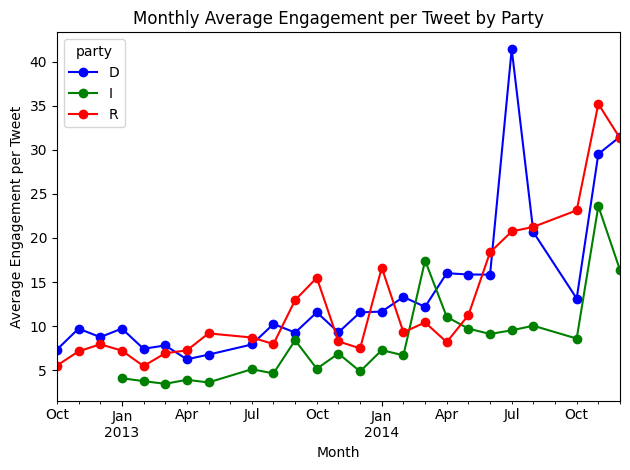

<Figure size 1000x400 with 0 Axes>

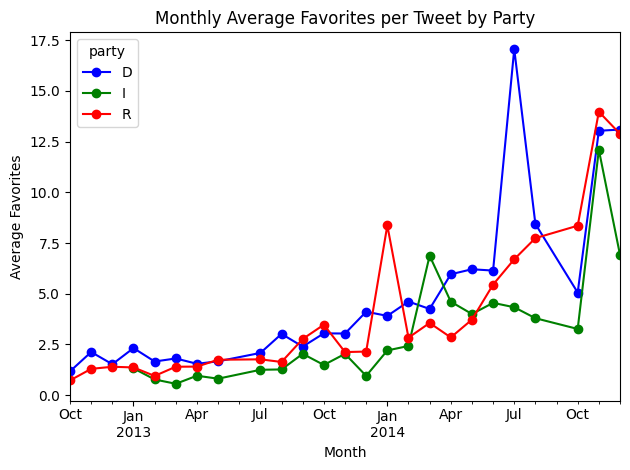

<Figure size 1000x400 with 0 Axes>

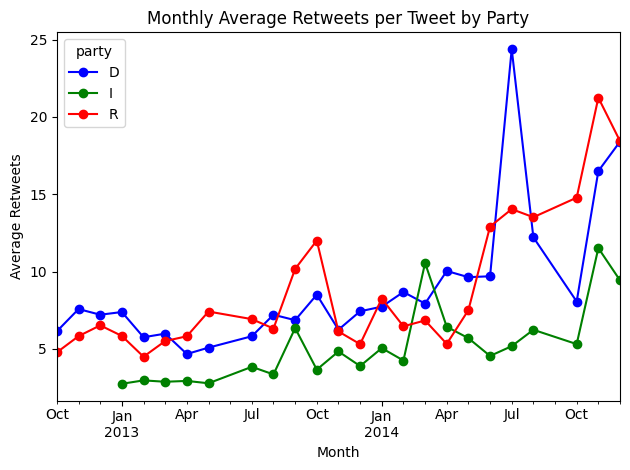

In [16]:
# Monthly average engagement by party (multi-line)

monthly_party_eng = (
    tweets_users
    .groupby(["month", "party"])[["favorite_count", "retweet_count", "engagement"]]
    .mean()
)

# Overall engagement line (one series per party)
monthly_party_total_eng = (
    monthly_party_eng["engagement"]
    .unstack("party")
    .sort_index()
)

display(monthly_party_total_eng.tail())

plt.figure(figsize=(10, 4))
colors = [PARTY_COLORS.get(str(p), "gray") for p in monthly_party_total_eng.columns]
monthly_party_total_eng.plot(kind="line", marker="o", color=colors)
plt.title("Monthly Average Engagement per Tweet by Party")
plt.xlabel("Month")
plt.ylabel("Average Engagement per Tweet")
plt.tight_layout()
plt.tight_layout()
plt.savefig(OUT_DIR / "monthly_average_engagement_per_tweet_by_party.png", dpi=300, bbox_inches="tight")
plt.show()

# Favorites and retweets separately by party (optional detailed view)

monthly_party_fav = (
    monthly_party_eng["favorite_count"]
    .unstack("party")
    .sort_index()
)

plt.figure(figsize=(10, 4))
colors = [PARTY_COLORS.get(str(p), "gray") for p in monthly_party_fav.columns]
monthly_party_fav.plot(kind="line", marker="o", color=colors)
plt.title("Monthly Average Favorites per Tweet by Party")
plt.xlabel("Month")
plt.ylabel("Average Favorites")
plt.tight_layout()
plt.tight_layout()
plt.savefig(OUT_DIR / "monthly_average_engagement_per_tweet_by_party.png", dpi=300, bbox_inches="tight")
plt.show()

monthly_party_rt = (
    monthly_party_eng["retweet_count"]
    .unstack("party")
    .sort_index()
)

plt.figure(figsize=(10, 4))
colors = [PARTY_COLORS.get(str(p), "gray") for p in monthly_party_rt.columns]
monthly_party_rt.plot(kind="line", marker="o", color=colors)
plt.title("Monthly Average Retweets per Tweet by Party")
plt.xlabel("Month")
plt.ylabel("Average Retweets")
plt.tight_layout()
plt.tight_layout()
plt.savefig(OUT_DIR / "monthly_average_engagement_per_tweet_by_party.png", dpi=300, bbox_inches="tight")
plt.show()

## 3. Hashtag Usage – Overall and by Party

hashtag  count
0      obamacare   7275
1           tcot   3319
2       smallbiz   1871
3           sotu   1845
4            irs   1828
5     mepolitics   1748
6    immigration   1597
7           jobs   1592
8       veterans   1347
9       benghazi   1332
10  raisethewage   1289
11           aca   1273
12         idpol   1261
13       renewui   1188
14           gop    996

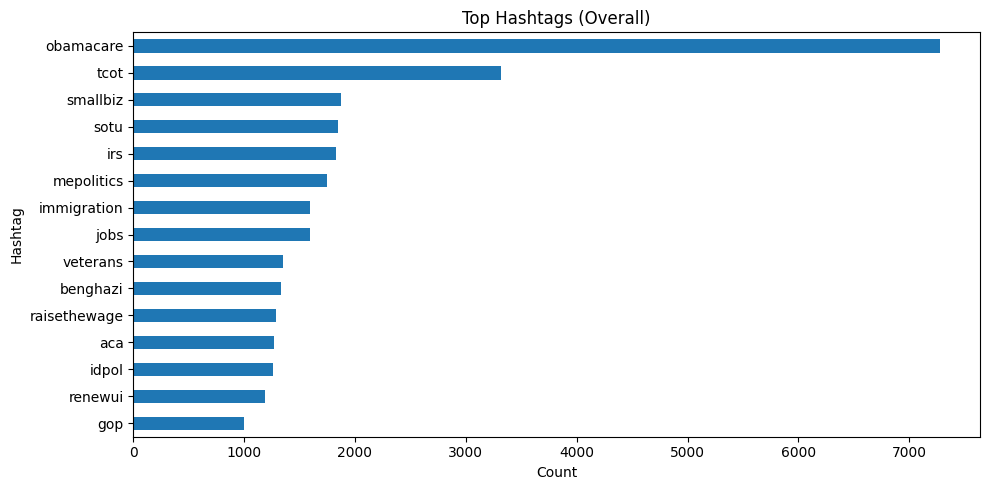

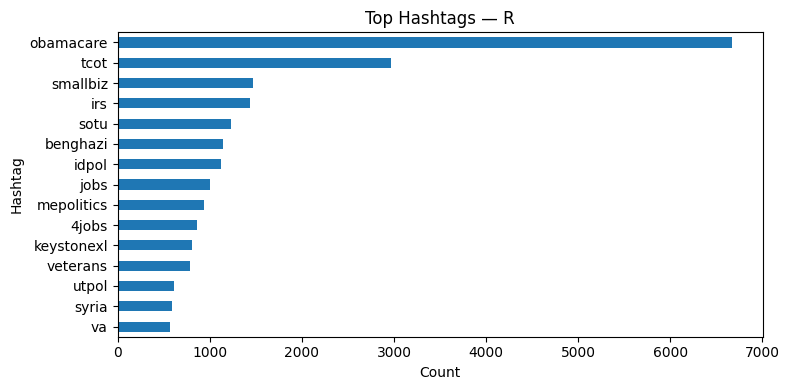

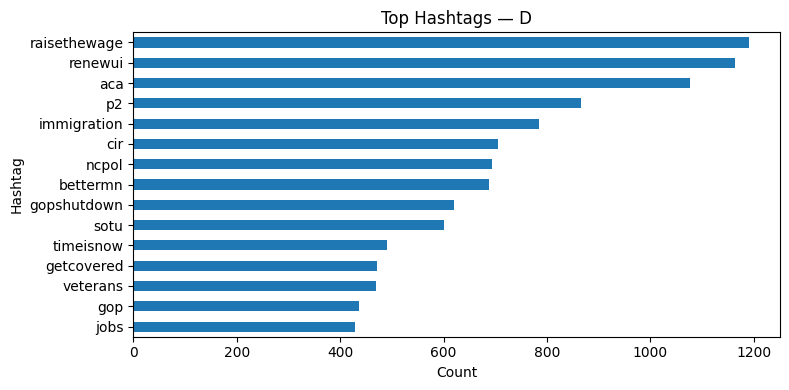

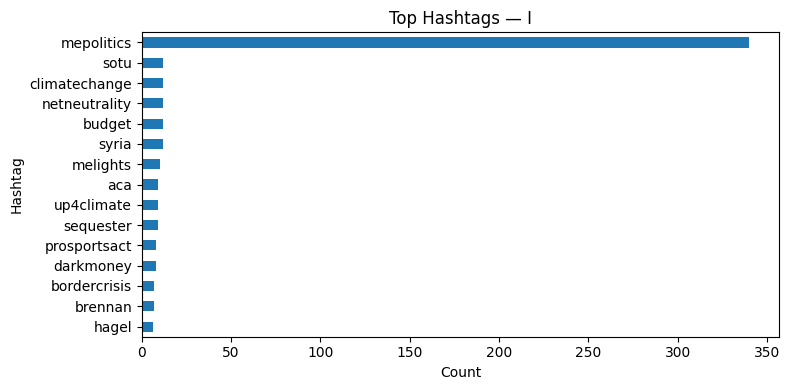

In [17]:
def extract_hashtags(text):
    return [h.lower() for h in re.findall(r"#(\w+)", str(text))]

if "text" not in tweets_users.columns:
    raise KeyError("Expected a 'text' column in tweets_users.")

tweets_users["hashtags"] = tweets_users["text"].apply(extract_hashtags)

# Overall top hashtags
all_ht = Counter(h for lst in tweets_users["hashtags"] for h in lst).most_common(25)
all_ht_df = pd.DataFrame(all_ht, columns=["hashtag", "count"])

display(all_ht_df.head(15))

plt.figure(figsize=(10, 5))
all_ht_df.head(15).set_index("hashtag")["count"].sort_values().plot(kind="barh")
plt.title("Top Hashtags (Overall)")
plt.xlabel("Count")
plt.ylabel("Hashtag")
plt.tight_layout()
plt.tight_layout()
plt.savefig(OUT_DIR / "top_hashtags_overall.png", dpi=300, bbox_inches="tight")
plt.show()

# Top hashtags by party
for p in tweets_users["party"].dropna().unique():
    subset = tweets_users[tweets_users["party"] == p]
    c = Counter(h for lst in subset["hashtags"] for h in lst)
    top_ht = c.most_common(15)
    party_df = pd.DataFrame(top_ht, columns=["hashtag", "count"])
    plt.figure(figsize=(8, 4))
    party_df.set_index("hashtag")["count"].sort_values().plot(kind="barh")
    plt.title(f"Top Hashtags — {p}")
    plt.xlabel("Count")
    plt.ylabel("Hashtag")
    plt.tight_layout()
    plt.tight_layout()
plt.savefig(OUT_DIR / "top_hashtags_overall.png", dpi=300, bbox_inches="tight")
plt.show()

<Figure size 1000x400 with 0 Axes>

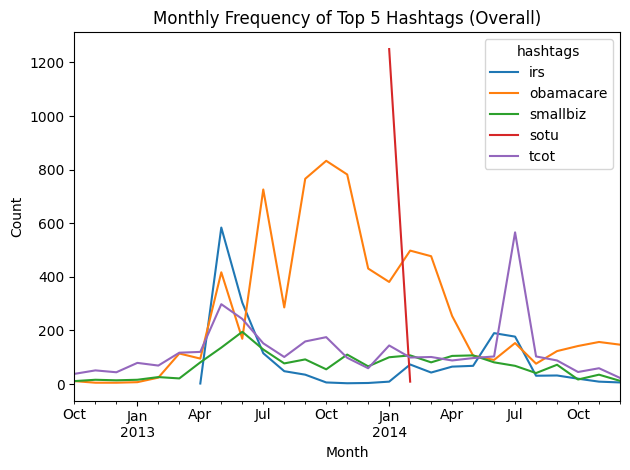

In [18]:
# Hashtag frequency over time for top 5 hashtags (overall)

top5_hashtags = all_ht_df.head(5)["hashtag"].tolist()

ht_long = tweets_users[["month", "hashtags"]].explode("hashtags")
ht_long = ht_long[ht_long["hashtags"].notna()].copy()

ht_long_top5 = ht_long[ht_long["hashtags"].isin(top5_hashtags)]

ht_time = (
    ht_long_top5
    .groupby(["month", "hashtags"])["hashtags"]
    .count()
    .unstack("hashtags")
    .sort_index()
)

plt.figure(figsize=(10, 4))
ht_time.plot(kind="line")
plt.title("Monthly Frequency of Top 5 Hashtags (Overall)")
plt.xlabel("Month")
plt.ylabel("Count")
plt.tight_layout()
plt.tight_layout()
plt.savefig(OUT_DIR / "monthly_frequency_of_top_5_hashtags_overall.png", dpi=300, bbox_inches="tight")
plt.show()

## 4. Topic Modeling (LDA)

In [22]:
# Prepare text corpus for LDA from monthly tweets

lda_df = tweets_users.copy()

if "text" not in lda_df.columns:
    raise KeyError("Expected a 'text' column in tweets_users.")

lda_df["text"] = lda_df["text"].fillna("").astype(str)

custom_stopwords = set([
    "the","a","an","and","or","of","in","to","is","for","on","with","at","by","this","that",
    "from","be","it","as","are","was","were","so","if","but","than","then","because","out","up",
    "down","just","over","about","after","before","into","no","not","too","very","can","will",
    "you","your","i","me","my","we","our","they","their","them","he","she","his","her","its",
    "do","does","did","done","have","has","had","all","who","what","when","where","why","how",
    "http","https","www","twitter","co","t","rt","amp"
])
all_stopwords = ENGLISH_STOP_WORDS.union(custom_stopwords)

texts = lda_df["text"].tolist()

vectorizer = CountVectorizer(
    stop_words=all_stopwords,
    max_df=0.4,
    min_df=30,
    max_features=5000
)
X = vectorizer.fit_transform(texts)
print("Document-term matrix shape:", X.shape)

Document-term matrix shape: (245858, 5000)


Topic 0: watch, today, live, hearing, ll, tune, morning, discuss, tomorrow, floor
Topic 1: jobs, new, women, job, today, time, economy, million, work, vote
Topic 2: today, day, happy, thank, thanks, great, honor, service, forward, family
Topic 3: great, today, thanks, meeting, va, students, school, new, morning, business
Topic 4: obamacare, president, house, obama, act, health, need, care, congress, americans


topic_id
0    40470
1    33836
2    52265
3    50940
4    68347
Name: count, dtype: int64

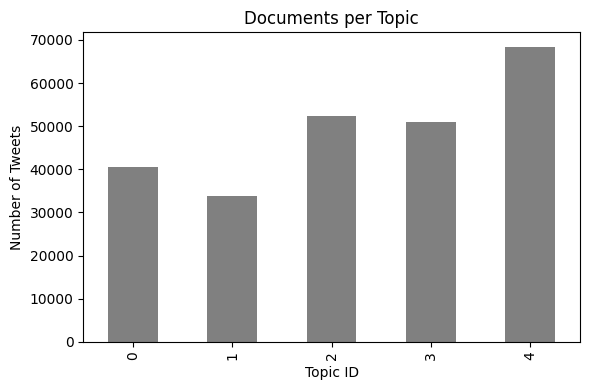

topic_id      0      1      2      3      4
party                                      
D         0.134  0.167  0.222  0.204  0.272
I         0.322  0.155  0.161  0.186  0.176
R         0.184  0.117  0.207  0.210  0.283
Unknown   0.157  0.149  0.215  0.204  0.276

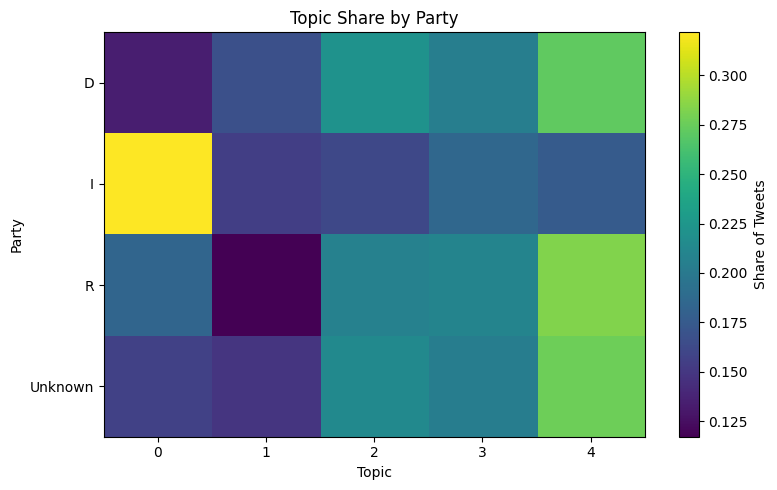

In [23]:
# Fit LDA model and inspect topics

# Faster LDA config
lda_model = LatentDirichletAllocation(
    n_components=5,
    learning_method="online",
    max_iter=3,
    batch_size=2048,
    n_jobs=-1,
    evaluate_every=0,
    random_state=42
)

W = lda_model.fit_transform(X)
H = lda_model.components_
terms = vectorizer.get_feature_names_out()

TOP_N = 10
for t, comp in enumerate(H):
    idx = np.argpartition(comp, -TOP_N)[-TOP_N:]
    idx_sorted = idx[np.argsort(comp[idx])][::-1]
    top_words = ", ".join(terms[i] for i in idx_sorted)
    print(f"Topic {t}: {top_words}")

lda_df["topic_id"] = W.argmax(axis=1)

topic_counts = lda_df["topic_id"].value_counts().sort_index()
display(topic_counts)

plt.figure(figsize=(6, 4))
topic_counts.plot(kind="bar", color=party_color_series(topic_counts.index))
plt.title("Documents per Topic")
plt.xlabel("Topic ID")
plt.ylabel("Number of Tweets")
plt.tight_layout()
plt.savefig(OUT_DIR / "documents_per_topic.png", dpi=300, bbox_inches="tight")
plt.show()

ct = pd.crosstab(
    lda_df["party"].fillna("Unknown"),
    lda_df["topic_id"],
    normalize="index"
)
display(ct.round(3))

plt.figure(figsize=(8, 5))
plt.imshow(ct.values, aspect="auto")
plt.colorbar(label="Share of Tweets")
plt.xticks(range(ct.shape[1]), ct.columns)
plt.yticks(range(ct.shape[0]), ct.index)
plt.title("Topic Share by Party")
plt.xlabel("Topic")
plt.ylabel("Party")
plt.tight_layout()
plt.savefig(OUT_DIR / "topic_share_by_party.png", dpi=300, bbox_inches="tight")
plt.show()

## 4a. Topic Word Clouds by Party

Reintroduce word clouds, using party-colored gradients. Each party uses its own colormap (Blues for D, Reds for R, Greens for I, etc.), and all word clouds are saved as PNGs under `outputs/`.

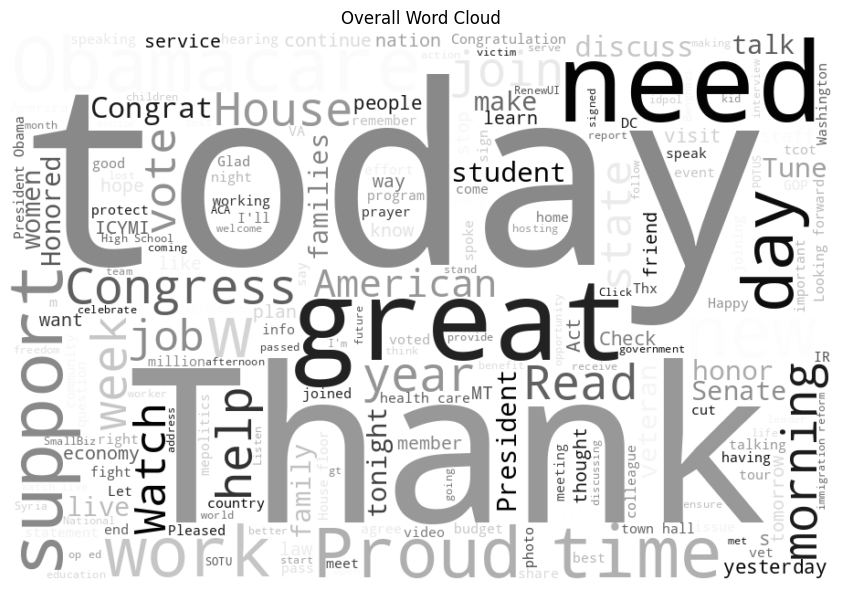

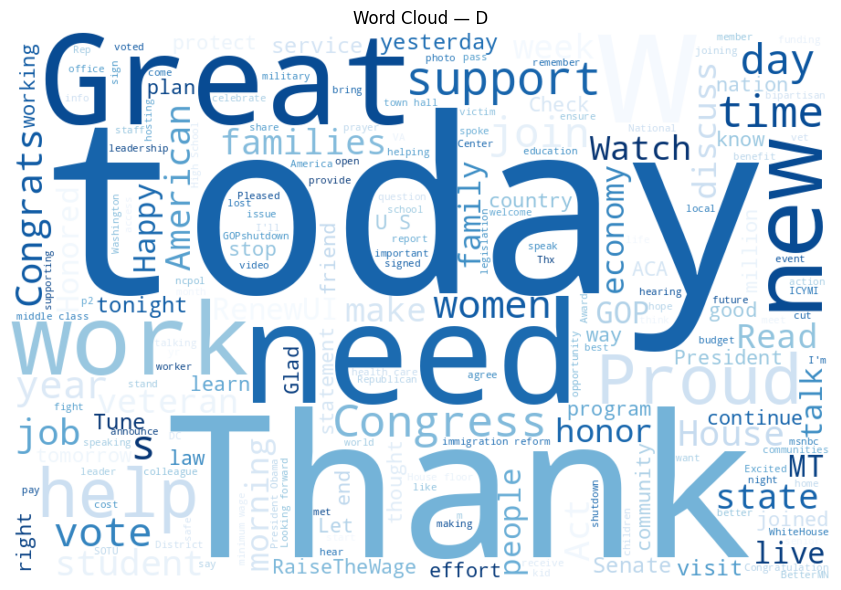

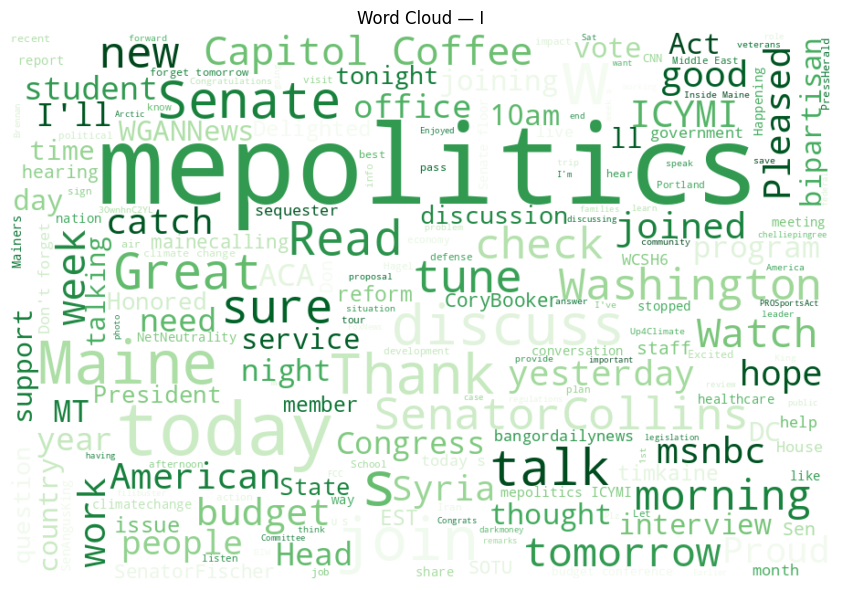

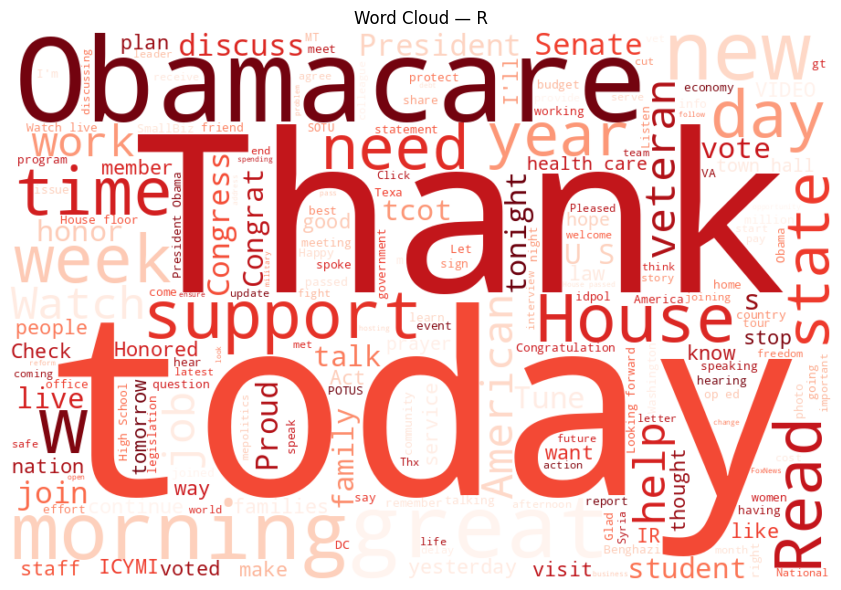

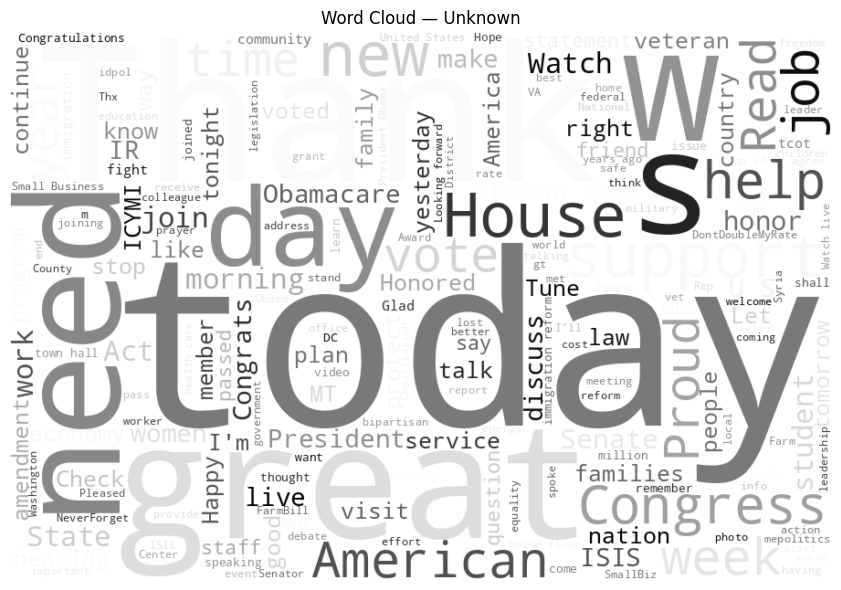

In [24]:
# Word clouds (overall + by party) with party-colored gradients

PARTY_CMAPS = {
    "D": "Blues",
    "R": "Reds",
    "I": "Greens",
    "Unknown": "Greys"
}

def show_wordcloud_party(texts, title, cmap="Greys", filename=None):
    text = " ".join(texts.dropna().astype(str))
    if not text.strip():
        print(f"No text for {title}, skipping.")
        return

    wc = WordCloud(
        width=900,
        height=600,
        background_color="white",
        stopwords=all_stopwords,
        colormap=cmap
    ).generate(text)

    plt.figure(figsize=(9, 6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)

    if filename is not None:
        out_path = OUT_DIR / filename
        plt.tight_layout()
        plt.savefig(out_path, dpi=300, bbox_inches="tight")

    plt.show()


# Overall word cloud (neutral colormap)
show_wordcloud_party(
    lda_df["text"],
    title="Overall Word Cloud",
    cmap="Greys",
    filename="wordcloud_overall.png"
)

# Party-specific word clouds
if "party" in lda_df.columns:
    for party, group in lda_df.groupby(lda_df["party"].fillna("Unknown")):
        cmap = PARTY_CMAPS.get(party, "Greys")
        safe_party = str(party).replace(" ", "_")
        fname = f"wordcloud_party_{safe_party}.png"
        show_wordcloud_party(
            group["text"],
            title=f"Word Cloud — {party}",
            cmap=cmap,
            filename=fname
        )
else:
    print("No 'party' column in lda_df; skipping party-level word clouds.")

## 4b. Topic Sentiment Within and Between Parties

Compute sentiment scores for each tweet and summarize:
- Overall sentiment by party (D vs R)
- Average sentiment by topic and party (topic × party matrix), with a heatmap.
All sentiment plots are saved as PNGs under `outputs/`.

Overall sentiment by party (D/R):


party      mean  median   count
0     D  0.269248  0.3612   85458
1     R  0.227712  0.2263  137244

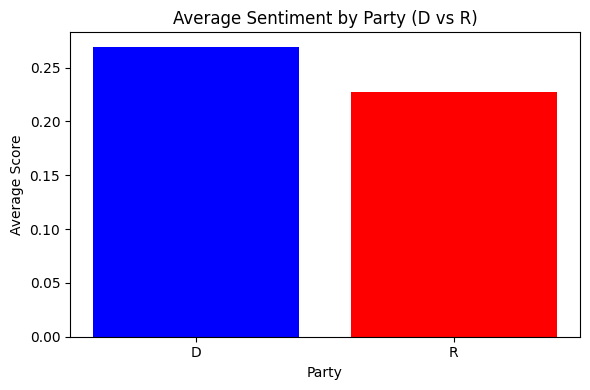

Average sentiment by topic and party (D/R):


party         D      R
topic_id              
0         0.162  0.120
1         0.220  0.199
2         0.425  0.415
3         0.414  0.390
4         0.117  0.052

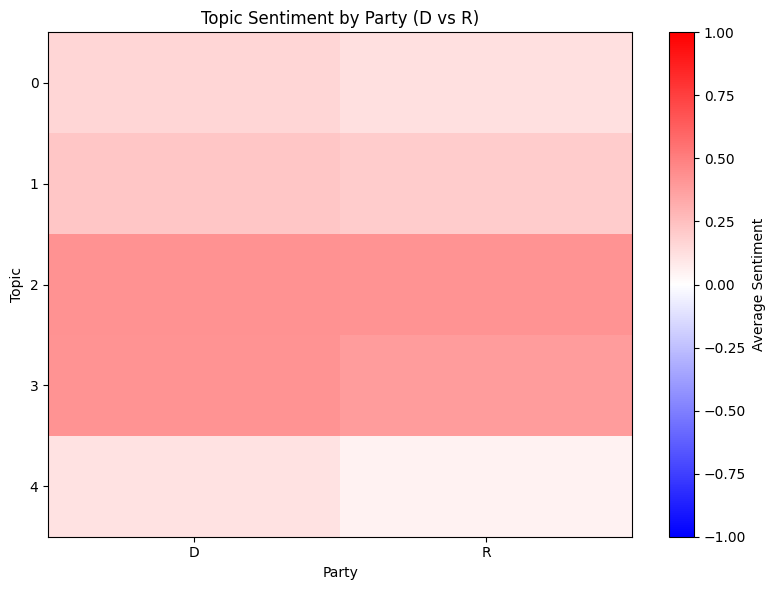

In [25]:
from nltk.sentiment import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()

lda_df["sentiment"] = lda_df["text"].astype(str).apply(
    lambda x: sia.polarity_scores(x)["compound"]
)

# Overall sentiment by party (focus on D and R)
mask_dr = lda_df["party"].isin(["D", "R"])
party_sent = (
    lda_df[mask_dr]
    .groupby("party")["sentiment"]
    .agg(["mean", "median", "count"])
    .reset_index()
)
print("Overall sentiment by party (D/R):")
display(party_sent)

plt.figure(figsize=(6, 4))
colors = [PARTY_COLORS.get(p, "gray") for p in party_sent["party"]]
plt.bar(party_sent["party"], party_sent["mean"], color=colors)
plt.title("Average Sentiment by Party (D vs R)")
plt.xlabel("Party")
plt.ylabel("Average Score")
plt.tight_layout()
out_path = OUT_DIR / "sentiment_by_party.png"
plt.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()

# Topic × party (D/R) sentiment matrix
topic_party_sent = (
    lda_df[mask_dr]
    .groupby(["topic_id", "party"])["sentiment"]
    .mean()
    .unstack("party")
)

print("Average sentiment by topic and party (D/R):")
display(topic_party_sent.round(3))

plt.figure(figsize=(8, 6))
plt.imshow(topic_party_sent.values, aspect="auto", cmap="bwr", vmin=-1, vmax=1)
plt.colorbar(label="Average Sentiment")
plt.xticks(range(topic_party_sent.shape[1]), topic_party_sent.columns)
plt.yticks(range(topic_party_sent.shape[0]), topic_party_sent.index)
plt.xlabel("Party")
plt.ylabel("Topic")
plt.title("Topic Sentiment by Party (D vs R)")
plt.tight_layout()
out_path = OUT_DIR / "sentiment_topic_party_heatmap.png"
plt.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()

## 5. Topic-Level Mention Networks

Below we construct spring-layout mention networks for each topic. Nodes are colored by party and sized by betweenness centrality. Sampling and node caps are used so the layouts do not take forever to generate.

Plotting topic 0...
Topic 0: using 250 nodes, 1048 edges.

Top 5 nodes by betweenness for Topic 0:
  RepHolding                 0.0141
  RepDeSantis                0.0124
  RepLukeMesser              0.0113
  RepKenMarchant             0.0088
  RepSteveStivers            0.0084


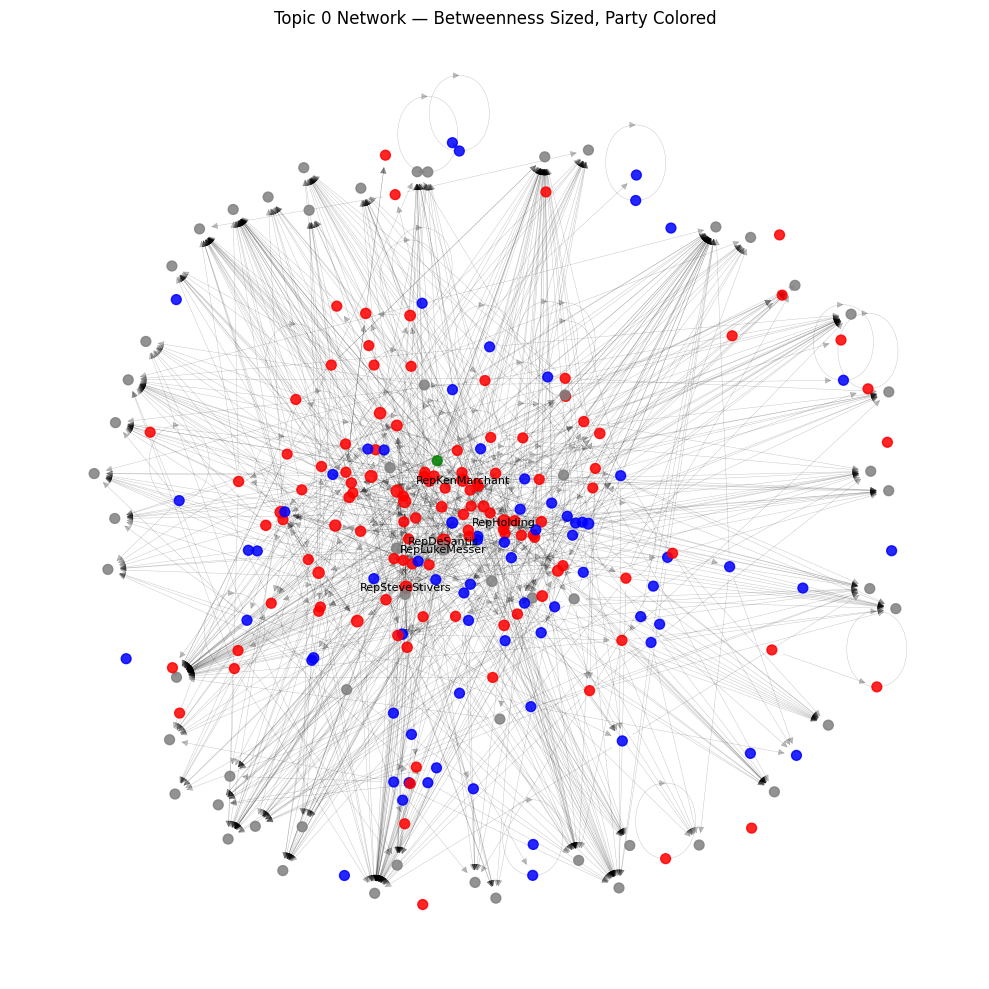

Plotting topic 1...
Topic 1: using 250 nodes, 556 edges.

Top 5 nodes by betweenness for Topic 1:
  SenJackReed                0.0068
  SenWarren                  0.0054
  SenAngusKing               0.0032
  MarkWarner                 0.0028
  nikiinthehouse             0.0027


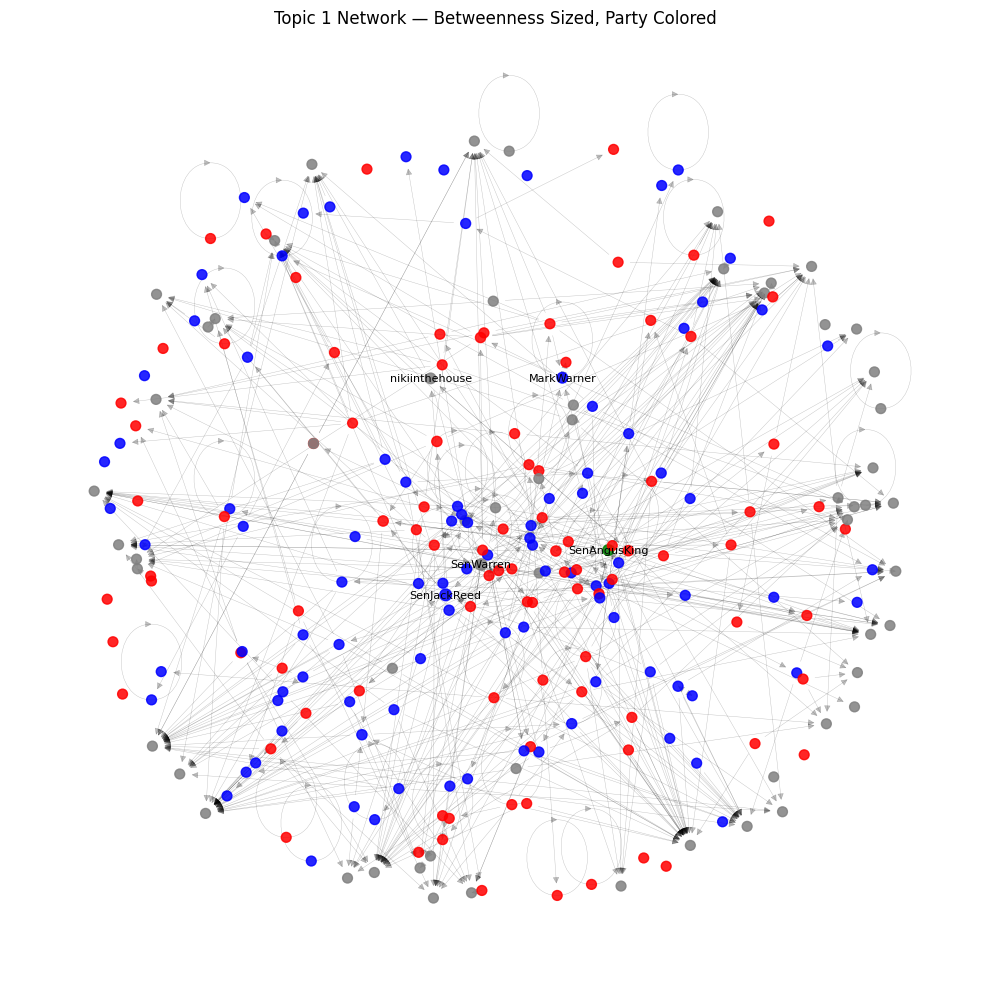

Plotting topic 2...
Topic 2: using 250 nodes, 468 edges.

Top 5 nodes by betweenness for Topic 2:
  RepGwenMoore               0.0056
  RepAndyBarr                0.0046
  RepJoeCourtney             0.0045
  RepHalRogers               0.0044
  USRepKeating               0.0040


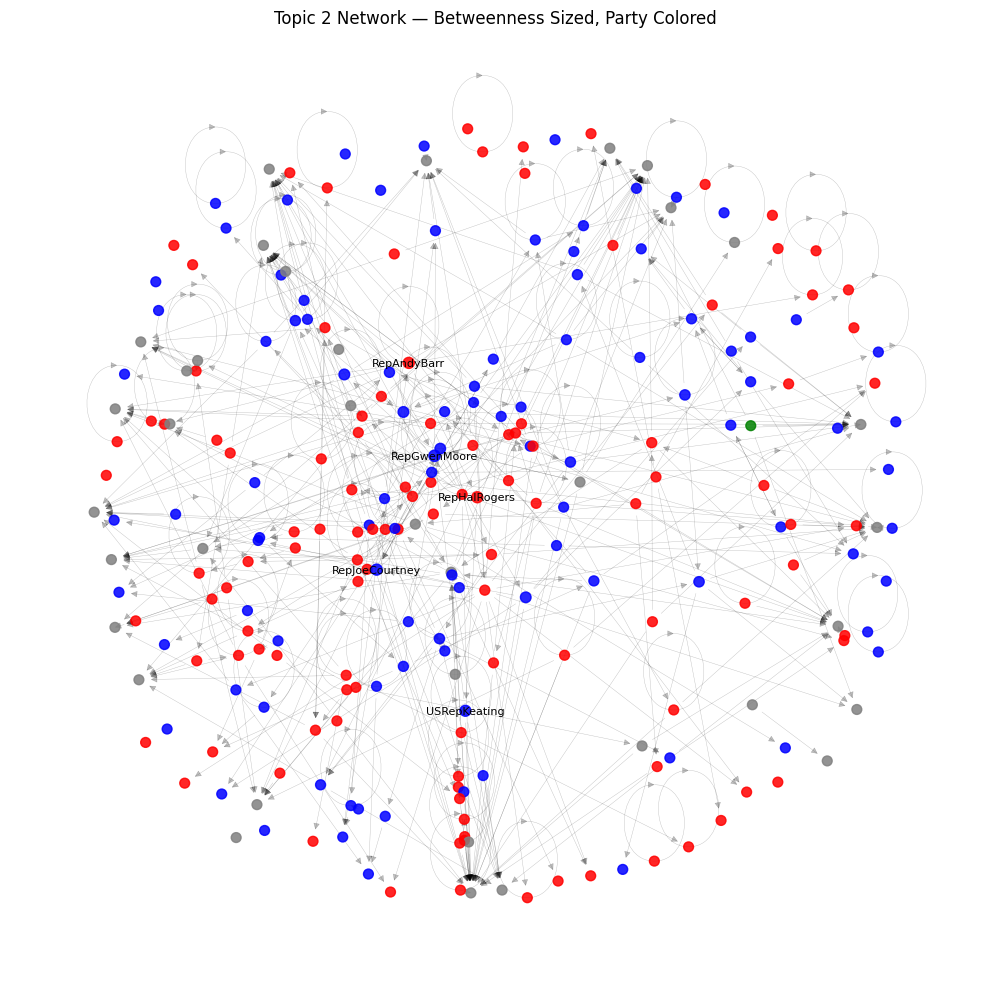

Plotting topic 3...
Topic 3: using 250 nodes, 461 edges.

Top 5 nodes by betweenness for Topic 3:
  SenDonnelly                0.0023
  SenatorWicker              0.0016
  RepRichmond                0.0015
  NancyPelosi                0.0014
  jaredpolis                 0.0011


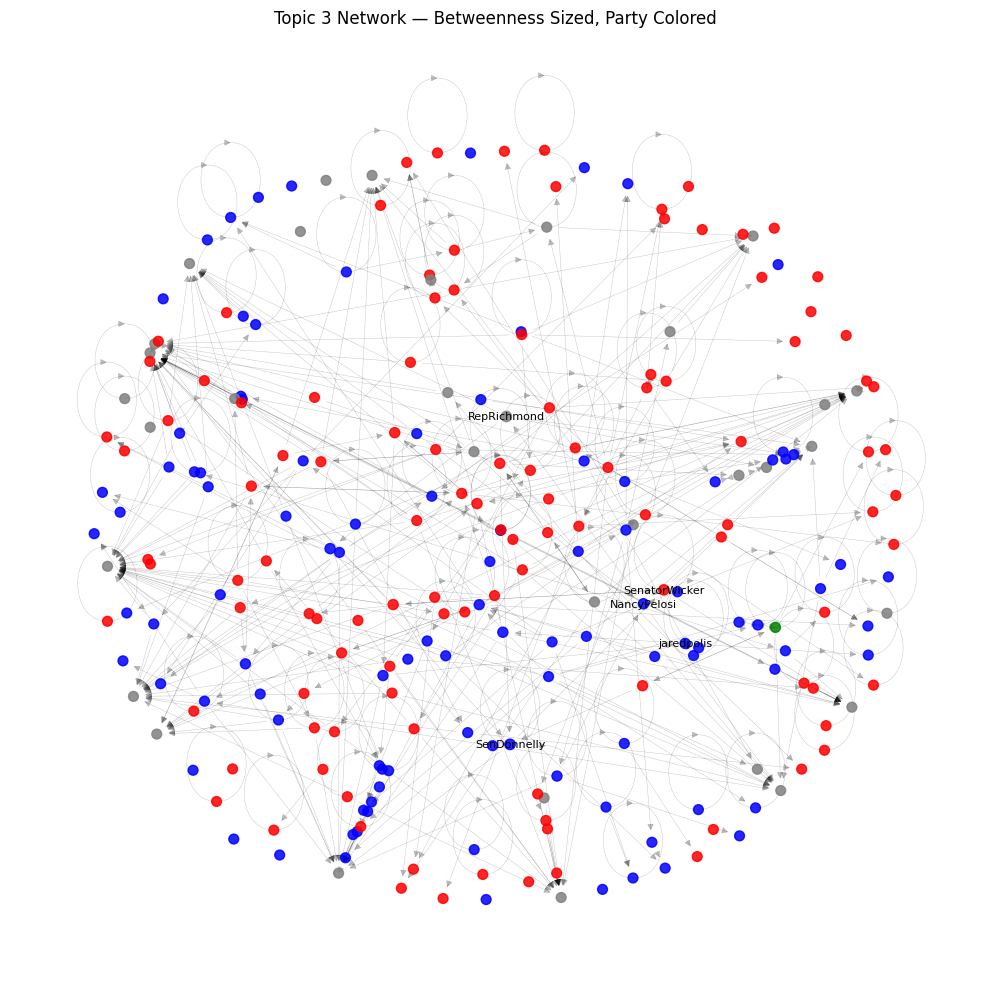

Plotting topic 4...
Topic 4: using 250 nodes, 891 edges.

Top 5 nodes by betweenness for Topic 4:
  RepGoodlatte               0.0187
  virginiafoxx               0.0186
  DarrellIssa                0.0174
  PatrickMcHenry             0.0171
  RepRonKind                 0.0151


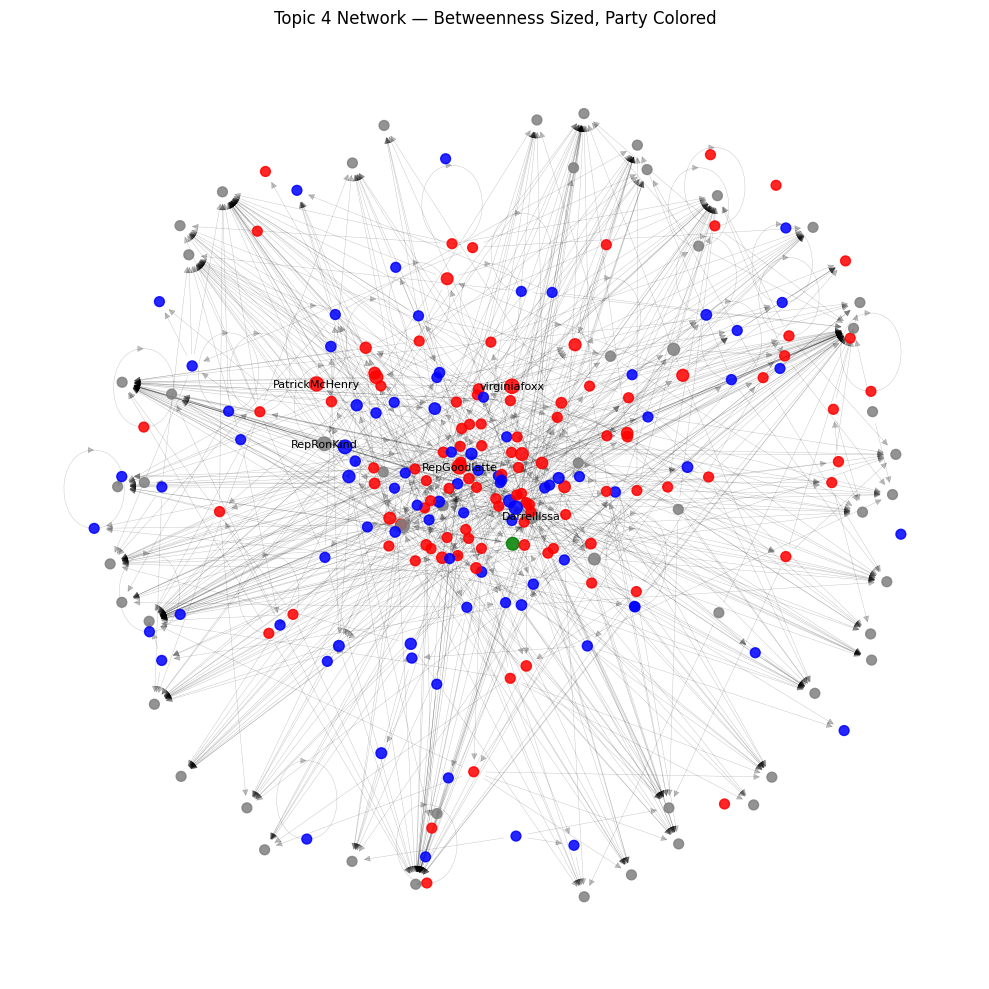

In [36]:
import re
import networkx as nx
import matplotlib.pyplot as plt

unique_topics = [0, 1, 2, 3, 4]

def party_color_single(p):
    return PARTY_COLORS.get(str(p), "gray")


def build_topic_mention_graph(df_topic):
    G = nx.DiGraph()

    for _, row in df_topic.iterrows():
        user = row.get("screen_name") or row.get("user_id")
        if pd.isna(user):
            continue

        user = str(user)
        G.add_node(user, party=row.get("party"))

        text = str(row.get("text", ""))
        mentions = re.findall(r"@(\w+)", text)

        for m in mentions:
            m = str(m)
            if not G.has_node(m):
                G.add_node(m)
            G.add_edge(user, m)

    return G


def plot_topic_network(
    topic_id,
    df=None,
    max_tweets=10000,
    max_nodes=250,
    figsize=(10, 10),
    seed=42
):
    if df is None:
        df = lda_df

    if "topic_id" not in df.columns:
        raise KeyError("Missing topic_id column in dataframe.")

    df_topic = df[df["topic_id"] == topic_id].copy()
    if df_topic.empty:
        print(f"No tweets for topic {topic_id}.")
        return None

    if len(df_topic) > max_tweets:
        df_topic = df_topic.sample(max_tweets, random_state=42)

    G = build_topic_mention_graph(df_topic)
    if G.number_of_nodes() == 0:
        print(f"Topic {topic_id} produced an empty graph.")
        return None

    deg = dict(G.degree())
    top_nodes = sorted(deg, key=deg.get, reverse=True)[:max_nodes]
    H = G.subgraph(top_nodes).copy()

    print(f"Topic {topic_id}: using {len(H.nodes())} nodes, {len(H.edges())} edges.")

    btw = nx.betweenness_centrality(H)
    sizes = [3000 * btw.get(n, 0.0) + 50 for n in H.nodes()]

    top_btw = sorted(btw.items(), key=lambda x: x[1], reverse=True)[:5]
    print(f"\nTop 5 nodes by betweenness for Topic {topic_id}:")
    for node, score in top_btw:
        print(f"  {node:<25}  {score:.4f}")

    colors = [party_color_single(H.nodes[n].get("party")) for n in H.nodes()]

    pos = nx.spring_layout(H, seed=seed)

    plt.figure(figsize=figsize)
    nx.draw_networkx_nodes(H, pos, node_color=colors, node_size=sizes, alpha=0.85)
    nx.draw_networkx_edges(H, pos, width=0.3, alpha=0.25)

    label_nodes = [n for n, _ in top_btw]
    labels = {n: str(n) for n in label_nodes}
    nx.draw_networkx_labels(H, pos, labels=labels, font_size=8)

    plt.title(f"Topic {topic_id} Network — Betweenness Sized, Party Colored")
    plt.axis("off")

    out_path = OUT_DIR / f"topic_{topic_id}_network.png"
    plt.tight_layout()
    plt.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.show()

    return H


for t in unique_topics:
    print(f"Plotting topic {t}...")
    plot_topic_network(t)